In [339]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import matplotlib as mpl
from mpltools import annotation
import time
from tqdm import tqdm


from scipy.io import loadmat, savemat
from C4theo_asymptotiqueValue_Calculus import C4_short, C4_long
from Physic_function_problem import *

from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
}

sns.set_theme(context = "notebook", style="ticks", rc=custom_params)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

In [585]:
from Double_Walls_Overdamped_Langevin_Cython import DoubleWallsLangevin_Cy

a = 1.519e-6
H = 20e-6
lD = 88.0e-9
lB = 526e-9
B = 5.0
T = 300
eta0 = 0.001
Nt_sub = 1

dt = 0.01
Nt = 1_000_000

tc_0 = time.time() 
brown = DoubleWallsLangevin_Cy(dt=dt, Nt=Nt,
                                               a=a, H=H, lD=lD, lB=lB, B=B,
                                               Nt_sub=Nt_sub, eta0=eta0,
                                               T=T, R0=None)#Instance of DoubleWallsLangevin class
brown.trajectory() #Compute trajectory of "brown"
print("Compute time= ", time.time()-tc_0)

Compute time=  0.6357049942016602


## Shoot of initial altitude $Z_0$ over $P_\mathrm{eq}$

In [ ]:
u = np.linspace(0.01,0.99, 100) # u in ]0,1[
F_inverse = brown.sample() # Call function

In [ ]:
# Shoot 1000 times z_eq value over Peq
z0_eq=brown.return_samples(1000)

In [ ]:
bins=100
binsPositions_eq, _, hist_Z0eq = brown.logarithmic_hist(position=z0_eq+brown.H, begin=1e-15, stop=7e-6, num=bins, )
P_Z0eq = hist_Z0eq / np.trapz(hist_Z0eq, binsPositions_eq*1e6)

In [ ]:
# Theoritical Peq
epsilon = brown.H*1e-3
z0_Peq = np.logspace(np.log(1e-20)/np.log(2), np.log(8e-6)/np.log(2), 1000, base=2)

Peq_theo =  brown.P_eq_Z(z0_Peq-brown.H)

In [ ]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
ax1 = plt.subplot(121)
ax1.plot(u, F_inverse(u), color=BlueUB)
ax1.set(
    xlabel = r"$U$",
    ylabel = r"$F^{-1}_\mathrm{eq}(U)$",
)
ax1.text(0.06, 0.92, r"(a)", transform=ax1.transAxes)

ax2 = plt.subplot(122)
ax2.semilogy((binsPositions_eq)*1e6, P_Z0eq, "o", color=BlueUB)
ax2.semilogy( z0_Peq*1e6, Peq_theo/np.trapz( Peq_theo , z0_Peq*1e6), "k-",)
ax2.set(
    xlabel = r"$Z_0~\mathrm{(\mu m)}$",
    ylabel = r"$P\mathrm{eq}(Z_0)$",
    xlim = (-0.5, 5),
    ylim = (5e-4, 5e0)
)
ax2.text(0.06, 0.92, r"(b)", transform=ax2.transAxes)

# plt.savefig("Figures/SampleFunction.pdf")

## Trajectory

In [ ]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)
M=10000
## TRAJECTOIRE
ax1 = plt.subplot(111)
ax11=ax1.twinx()
l1 = ax11.plot(np.arange(Nt)[:M] * dt, (brown.Zn[:M]+H)*1e6, color="tab:green", label=r"$Z_n+H$")
ax11.set_ylabel("$Z_n~\mathrm{(\mu m)}$",color="tab:green")
ax11.tick_params(axis='y', labelcolor="tab:green")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# ax11.set_ylim(0, 4)
l2 = ax1.plot(np.arange(Nt)[:M] * dt, brown.Xn[:M]*1e6, color=BlueUB, label=r"$X_n$")
lns = l1 + l2
labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc='upper left', frameon=False, fontsize=8)
ax1.set(
    xlabel = r"$t_n~\mathrm{(s)}$",
    ylabel = r"$X_n ~\mathrm{(\mu m)}$",
)
ax1.yaxis.label.set_color(BlueUB)

# plt.savefig("Figures/Trajectory_cy.pdf")

## Standard deviation

In [ ]:
tau_x, msd_x = brown.MSD(axis="x") #Invocation de la méthode MSD pour calculer la déviation standard de la trajectoire
tau_z, msd_z = brown.MSD(axis="z")
dt_theo = np.linspace(brown.dt*1e-1, brown.dt*brown.Nt*1e1, 100)

## Equilibrium distribution

In [ ]:
# Numerical datas
bins=100
binsPositions, _, hist_z = brown.logarithmic_hist(position=brown.Zn+brown.H, begin=1e-15, stop=7e-6, num=bins, )
pdf = hist_z / np.trapz(hist_z, binsPositions*1e6)

In [680]:
# Theoritical datas
z_Peq = np.logspace(np.log(1e-21)/np.log(2), np.log(8e-6)/np.log(2), 1000, base=2)
epsilon = H*1e-3
z_theo = np.linspace(-H-epsilon, H-epsilon, 1000)

Peq = P_eq(z_theo, B, lD, lB, H)
Peq_normalised = Peq/np.trapz( Peq, z_theo)

mean_Dx = np.trapz(Peq_normalised*D_x(z_theo, a, eta0, H), z_theo)
mean_Dz = np.trapz(Peq_normalised*D_z(z_theo, a, eta0, H), z_theo)

dz_theo = np.linspace(-2*(H-epsilon), 2*(H-epsilon), 1000)
P_dZ_longTime = [np.trapz(Peq * P_eq(z_theo+dz, B, lD, lB, H), z_theo) for dz in dz_theo] #Compute P(dZ) at long time
P_dZ_longTime = P_dZ_longTime/np.trapz(P_dZ_longTime, dz_theo)
plateauZ = np.trapz(dz_theo**2 * P_dZ_longTime, dz_theo)

## Plots

In [ ]:
plt.figure(figsize=(1.5 * 3.375, 1.5 * 3.375 / 1.68), tight_layout=True)

ax2 = plt.subplot(121)
ax2.semilogy(binsPositions*1e6, pdf, "d", color="green", label=r"$\mathrm{Simulation}$")
ax2.plot( z_Peq*1e6, brown.P_eq_Z(z_Peq-brown.H)/np.trapz( brown.P_eq_Z(z_Peq-brown.H) , z_Peq*1e6), "k-", label=r"$\mathrm{Theory}$",)
ax2.set(
    xlabel = r"$Z_{n}+H~\mathrm{(\mu m)}$", 
    ylabel = r"$P_\mathrm{eq}(Z_n)$",
    xlim = (None,5.5),
    ylim = (5e-5,None),
)
ax2.text(0.85, 0.92, r"(a)", transform=ax2.transAxes)


ax1 = plt.subplot(122)
ax1.loglog(tau_x, msd_x*1e12, "o", color=BlueUB)
ax1.loglog(tau_z, msd_z*1e12, "d", color="tab:green")
ax1.plot(dt_theo, 2*mean_Dx*1e12*dt_theo, "--", color="k")#mediumblue
ax1.plot(dt_theo, 2*mean_Dz*1e12*dt_theo, "-", color="k") #darkgreen
ax1.plot(np.linspace(10, 10000, 100), plateauZ*1e12*np.ones(100), ":", color="k")
ax1.set(
    xlabel = r"$\tau ~\mathrm{(s)}$",
    ylabel = r"$\langle (R_{i,n})^2 \rangle~\mathrm{(\mu m)}^2$",
    xlim=(brown.dt/2, brown.dt*brown.Nt),
    ylim=(1e-4, 2e2),
)
ax1.text(0.05, 0.92, r"(b)", transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_xticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)

plt.savefig("Figures/Analyse_cy.pdf")

# Plots large gap (Chap 3)

In [713]:
bins=100
binsPositions, err_binsPos, hist_z = brown.logarithmic_hist(position=brown.Zn+brown.H, begin=1e-15, stop=7e-6, num=bins, )
Peq = hist_z / np.trapz(hist_z, binsPositions*1e6)
z_PeqTheo = np.linspace(1e-25,6e-6, 1000)

In [588]:
print("1/lB =",1/brown.lB/1e6, "micrometer")

1/lB = 1.9011406844106464 micrometer


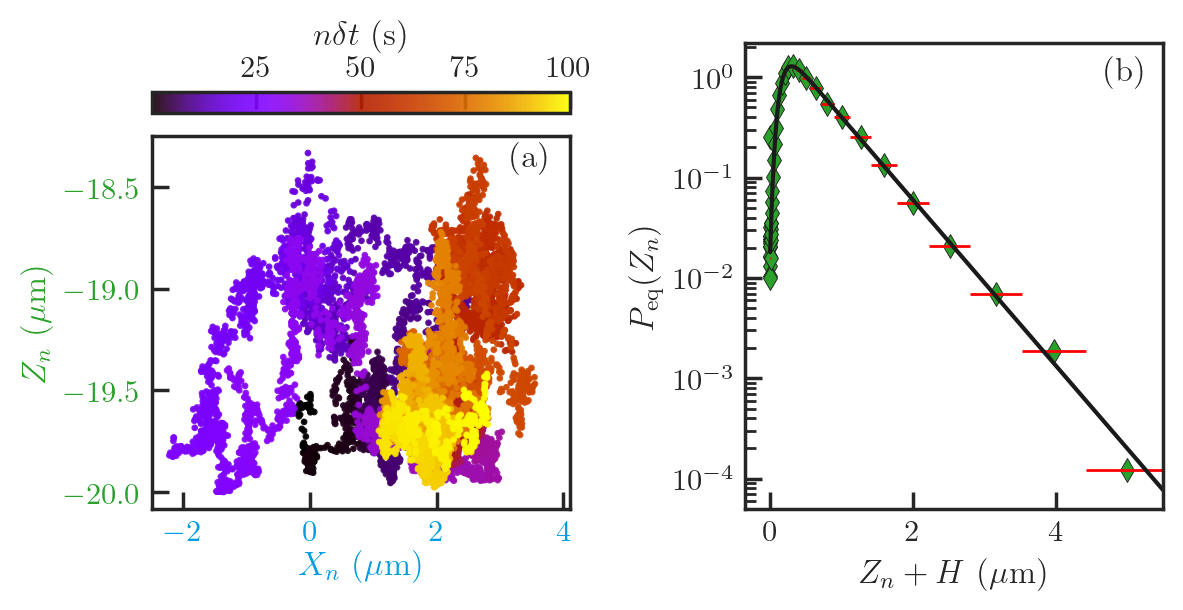

In [717]:
taille_marque = 6
taille_ligne = 1.5

fig, ax = plt.subplots(1,2, figsize=(1.8 * 3.375, 1.6 * 3.375 / 1.68), tight_layout=True)
Min = 1
Max = 10000
x = brown.Xn[Min:Max]
z = brown.Zn[Min:Max]
t = np.linspace(brown.dt,brown.dt*brown.Nt,brown.Nt)[Min:Max]
sc = ax[0].scatter(x*1e6, z*1e6, c=t, marker="o", cmap='gnuplot', alpha=.9, s=2)
ax[0].set_xlabel('o', labelpad = 1)
ax[0].set(
    xlabel = r"$X_{n}~\mathrm{(\mu m)}$", 
    ylabel = r"$Z_n~(\mathrm{\mu m})$",
    xlim = (-2.5,4.1),
    # ylim = (5e-5,None),
)
ax[0].text(0.86, 0.92, r"(a)", transform=ax[0].transAxes)
ax[0].yaxis.label.set_color("tab:green")
ax[0].xaxis.label.set_color(BlueUB)
ax[0].tick_params(axis='y', labelcolor="tab:green")
ax[0].tick_params(axis='x', labelcolor=BlueUB)


# ax[1].semilogy(binsPositions*1e6, Peq, "d", color="green", label=r"$\mathrm{Simulation}$")
ax[1].errorbar(binsPositions*1e6, Peq, xerr=err_binsPos/2*1e6, fmt='d', linestyle="",color="tab:green",ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque)
ax[1].semilogy( z_PeqTheo*1e6, brown.P_eq_Z(z_PeqTheo-brown.H)/np.trapz( brown.P_eq_Z(z_PeqTheo-brown.H) , z_PeqTheo*1e6), "k-", label=r"$\mathrm{Theory}$", linewidth=taille_ligne)
ax[1].set(
    xlabel = r"$Z_{n}+H~\mathrm{(\mu m)}$", 
    ylabel = r"$P_\mathrm{eq}(Z_n)$",
    xlim = (None,5.5),
    ylim = (5e-5,None),
)
ax[1].text(0.86, 0.92, r"(b)", transform=ax[1].transAxes)
fig.colorbar(sc, ax=ax[0], label=r"$n\delta t~(\mathrm{s})$",location="top")

plt.savefig("Figures/Traj_Peq.pdf")

# PDF of displacements

In [198]:
# Z datas
SumHistZ_Ns100 = np.load('C4_Datas/PDFz_Ns100.npy') #PDF(\tau, \Delta Z) sum over 100 trajectories
Ntau, bins = np.shape(SumHistZ_Ns100)
Ns = 100

list_Ntau = np.logspace(np.log(1)/np.log(10), np.log(1000001)/np.log(10),120).astype(int)
list_Ntau = np.unique(list_Ntau)
tau_z = np.array(list_Ntau) * dt #list of lag time to cumpue C4


listdZ = np.zeros([Ntau,bins])
D_0 = kBT/(6*np.pi*eta0*a)
for n, i in enumerate(list_Ntau):
    tau = dt*i
    if tau<50:
        Sigma = np.sqrt(2*D_0*tau)
        listdZ[n,:] = np.linspace(-6*Sigma,+6*Sigma, bins)
    else:
        listdZ[n,:] = np.linspace(-15e-6, 15e-6, bins)

In [510]:
Sum_Hist = loadmat("Large_Gap/SIMU-SumHist_Ns-x_2097378_Ns-z_100_Nt_1e6_dt_1e-2_For4TimesTau.mat", squeeze_me=True)

In [511]:
dx_0, SumHist_x0 = Sum_Hist['dx_0, Sum_Hist_x0']
dx_1, SumHist_x1 = Sum_Hist['dx_1, Sum_Hist_x1']
dx_2, SumHist_x2 = Sum_Hist['dx_2, Sum_Hist_x2']
dx_3, SumHist_x3 = Sum_Hist['dx_3, Sum_Hist_x3']

dz_0, SumHist_z0 = Sum_Hist['dz_0, Sum_Hist_z0']
dz_1, SumHist_z1 = Sum_Hist['dz_1, Sum_Hist_z1']
dz_2, SumHist_z2 = Sum_Hist['dz_2, Sum_Hist_z2']
dz_3, SumHist_z3 = Sum_Hist['dz_3, Sum_Hist_z3']

tauX = Sum_Hist['tau_x_selec']
tauZ = Sum_Hist['tau_z_selec']
tauX,tauZ

(array([1.0000e-02, 2.3290e+01, 9.5400e+01, 1.9306e+02]),
 array([1.0000e-02, 2.3880e+01, 9.6200e+01, 1.9306e+02]))

In [566]:
normalization0 = np.trapz(SumHist_x0, dx_0*1e6)
err_PDF_dx0 = np.zeros(len(dx_0))
for i in range(len(SumHist_x0)):
    try:
        err_PDF_dx0[i] = SumHist_x0[i]  / np.sqrt(SumHist_x0[i]) / normalization0
    except RuntimeWarning:
        err_PDF_dx0[i] = 0
        
PDF_dx0 = SumHist_x0 / normalization0
del normalization0

In [564]:
normalization2 = np.trapz(SumHist_x2, dx_2*1e6)
err_PDF_dx2 = np.zeros(len(dx_2))
for i in range(len(SumHist_x2)):
    try:
        err_PDF_dx2[i] = SumHist_x2[i]  / np.sqrt(SumHist_x2[i]) / normalization2
    except RuntimeWarning:
        err_PDF_dx2[i] = 0

PDF_dx2 = SumHist_x2 / normalization2
del normalization2

In [565]:
normalization_z0 = np.trapz(SumHist_z0, dz_0*1e6)
err_PDF_dz0 = np.zeros(len(dz_0))
for i in range(len(SumHist_z0)):
    try:
        err_PDF_dz0[i] = SumHist_z0[i]  / np.sqrt(SumHist_z0[i]) / normalization_z0
    except RuntimeWarning:
        err_PDF_dz0[i] = 0
        
PDF_dz0 = SumHist_z0 / normalization_z0
del normalization_z0

In [556]:
normalization_z2 = np.trapz(SumHist_z2, dz_2*1e6)
err_PDF_dz2 = np.zeros(len(dz_2))
for i in range(len(SumHist_z2)):
    try:
        err_PDF_dz2[i] = SumHist_z2[i]  / np.sqrt(SumHist_z2[i]) / normalization_z2
    except RuntimeWarning:
        err_PDF_dz2[i] = 0

PDF_dz2 = SumHist_z2/ normalization_z2
del normalization_z2

In [ ]:
# normalization_z3 = np.trapz(SumHist_z3, dz_3*1e6)
# err_PDF_dz3 = np.zeros(len(dz_3))
# for i in range(len(SumHist_z3)):
#     try:
#         err_PDF_dz3[i] = SumHist_z3[i]  / np.sqrt(SumHist_z3[i]) / normalization_z3
#     except RuntimeWarning:
#         err_PDF_dz3[i] = 0
#
# PDF_dz3 = SumHist_z3/ normalization_z3
# del normalization_z3

In [520]:
dxCOURT = np.linspace(-0.4e-6, 0.4e-6, 1000)
dxLONG = np.linspace(-60e-6, 60e-6, 1000)
dzCOURT = np.linspace(-0.4e-6, 0.4e-6, 1000)
dzLONG = np.linspace(-2*H, 2*H, 1000)

## Gaussian theories
Gauss_x0 = gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*dts[0]))
Gauss_z0 = gauss(dzCOURT, 0, np.sqrt(2*mean_Dz*dts[0]))
Gauss_x2 = gauss(dxLONG, 0, np.sqrt(2*mean_Dx*dts[2]))


In [521]:
# Theory along X narmalized compute from eingen values
theoriePDF0p01 = loadmat("Large_Gap/PDF_ForExpsParam_and_t=0p01_zMax=4_Nmesh=400.mat")
theoriePDF1p09 = loadmat("Large_Gap/PDF_ForExpsParam_and_t=1p09_zMax=4_Nmesh=400.mat")
theoriePDF95p4 = loadmat("Large_Gap/PDF_ForExpsParam_and_t=95p4_zMax=8_Nmesh=400.mat")

theo_PDF_x0 = theoriePDF0p01["P"]
theo_dx_0 = theoriePDF0p01["x"]

theo_PDF_x1 = theoriePDF1p09["P"]
theo_dx_1 = theoriePDF1p09["x"]

theo_PDF_x2 = theoriePDF95p4["P"]
theo_dx_2 = theoriePDF95p4["x"]

del theoriePDF0p01, theoriePDF1p09, theoriePDF95p4

In [523]:
# Theory along Z
PDF_theory_z_short = P_Di_short_time(dzCOURT, dts[0], D_z, a, eta0, B, lD, lB, H)
PDF_theory_z_long = Pdeltaz_long(dzLONG, B, lD, lB, H)
PDF_theory_x_short = P_Di_short_time(dxCOURT, dts[0], D_x, a, eta0, B, lD, lB, H)
PDF_theory_x_long = P_Di_short_time(dxLONG, dts[2], D_x, a, eta0, B, lD, lB, H)

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 71.07it/s]


In [524]:
## EXPERIENCE from FARÉS

experience = loadmat("Large_Gap/C4_kurtosis_semi_experimental_exp_20211019_from_20221003.mat")
experience_C4 = experience["C4"][0]
experience_errC4 = experience["err_C4"][0]
experience_Kurtosis = experience["kurtosis"][0]
experience_errKurtosis = experience["err_kurtosis"][0]
experience_time = experience["time"][0]

experience_dX_0p01 = experience["pdf_0"]["bins_center"][0][0][0]
experience_PDF_0p01 = experience["pdf_0"]["pdf"][0][0][0]
experience_PDFstd_0p01 = experience["pdf_0"]["pdf_err"][0][0][0]

experience_dX_1 = experience["pdf_2"]["bins_center"][0][0][0]
experience_PDF_1 = experience["pdf_2"]["pdf"][0][0][0]
experience_PDFstd_1 = experience["pdf_2"]["pdf_err"][0][0][0]

del experience
# experience

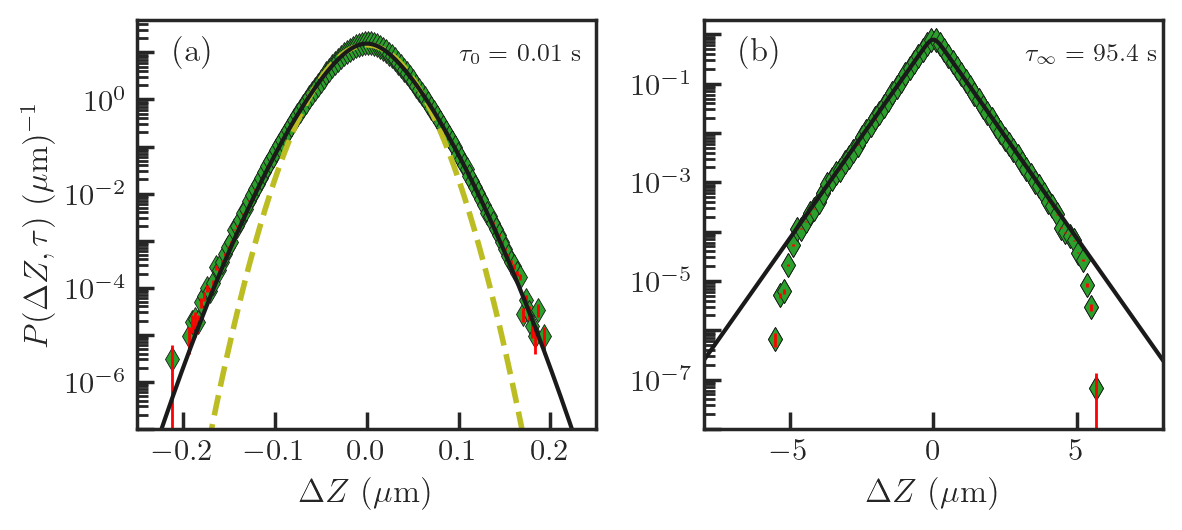

In [583]:
plt.figure(figsize=(1.8 * 3.375, 1.4 * 3.375 / 1.68), tight_layout=True)
taille_marque = 6
taille_ligne = 2


#####################
ax2 = plt.subplot(121)#Short Z
ax2.semilogy(dzCOURT*1e6, Gauss_z0/np.trapz(Gauss_z0,dzCOURT*1e6), "--", color="tab:olive", linewidth=taille_ligne)
# ax2.semilogy(dz_0*1e6,PDF_dz0, "d", color="tab:green", markersize=taille_marque)
ax2.errorbar(dz_0*1e6, PDF_dz0,yerr=err_PDF_dz0, fmt='d', linestyle="",color="tab:green",ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax2.semilogy(dzCOURT*1e6, PDF_theory_z_short/np.trapz(PDF_theory_z_short, dzCOURT*1e6), "k-", linewidth=1.5)
ax2.set(
    ylabel = r"$P(\Delta Z, \tau)~(\mathrm{\mu m})^{-1}$",
    xlabel = r"$\Delta Z~\mathrm{(\mu m)}$", 
    xlim = (-0.25, 0.25),
    ylim = (1e-7, 5e1),
)
ax2.text(0.08, 0.9, r"(a)", transform=ax2.transAxes)
ax2.text(0.7, 0.9, r"$\tau_0= $ "+ str(dts[0]) + " s", fontsize=9, transform=ax2.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2_ticks = ax2.get_yticklabels()
for i in ax2_ticks:
    i.set_visible(False)
for n, i in enumerate(ax2_ticks):
    if n%2==0:i.set_visible(True)

#####################
ax4 = plt.subplot(122)#Long Z
ax4.semilogy(dz_2*1e6,PDF_dz2, "d", color="tab:green", markersize=taille_marque)
ax4.errorbar(dz_2*1e6, PDF_dz2,yerr=err_PDF_dz2, fmt='d', linestyle="",color="tab:green",ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax4.semilogy(dzLONG*1e6, PDF_theory_z_long/np.trapz(PDF_theory_z_long, dzLONG*1e6), "k-", linewidth=1.5)
ax4.set(
    xlabel = r"$\Delta Z~\mathrm{(\mu m)}$", 
    xlim = (-8,8),
    ylim = (1e-8,2e0),
)
ax4.text(0.08, 0.9, r"(b)", transform=ax4.transAxes)
ax4.text(0.7, 0.9, r"$\tau_\infty = $ "+ str(dts[2]) + " s", fontsize=9, transform=ax4.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax4.yaxis.set_major_locator(locmaj)
ax4.yaxis.set_minor_locator(locmin)
ax4.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax4_ticks = ax4.get_yticklabels()
for i in ax4_ticks:
    i.set_visible(False)
for n, i in enumerate(ax4_ticks):
    if n%2==0:i.set_visible(True)
    
plt.savefig("Figures/PDFs_Z.pdf")

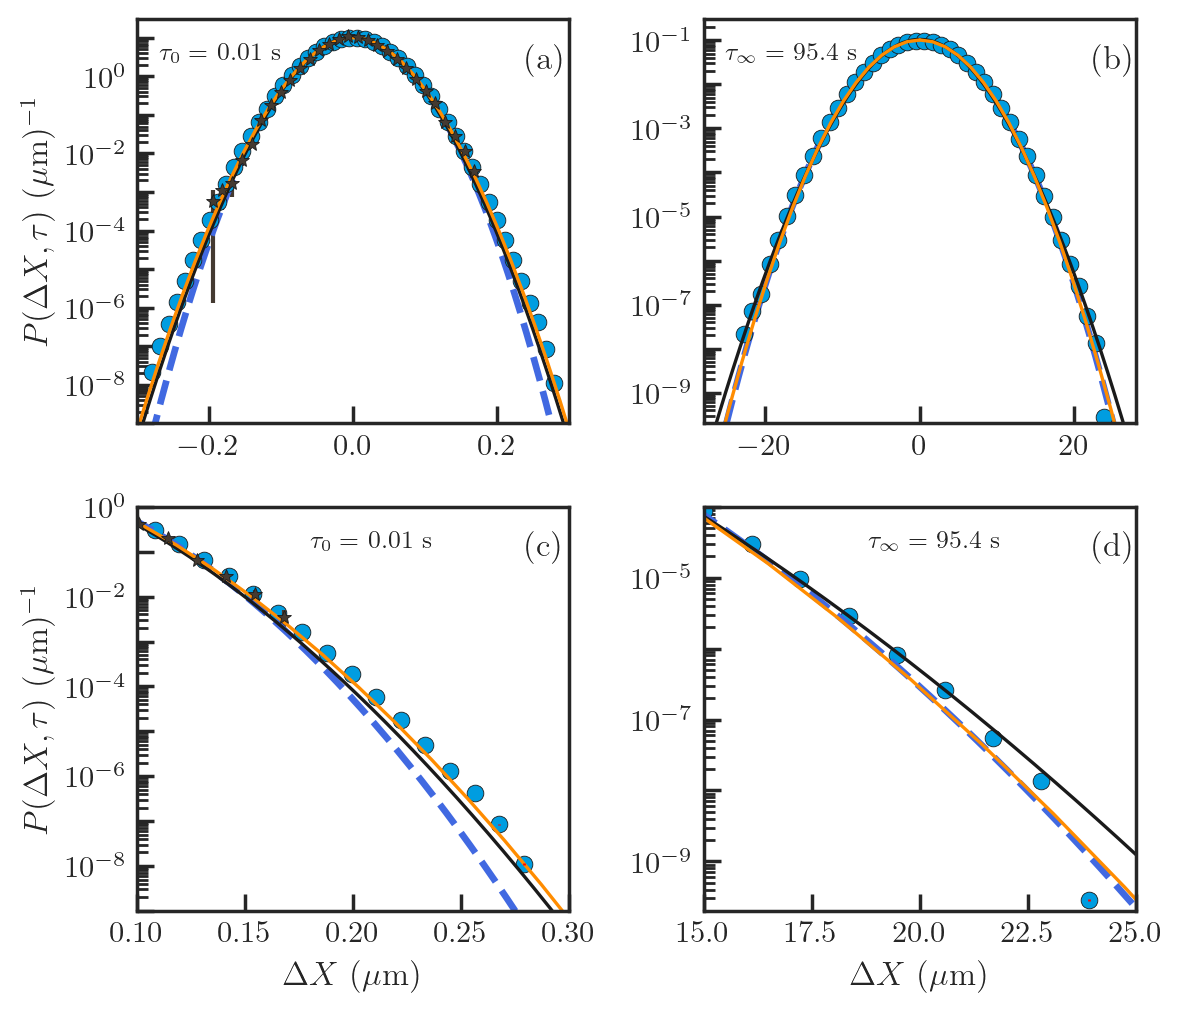

In [584]:
plt.figure(figsize=(1.8 * 3.375, 2* 1.3 * 3.375 / 1.68), tight_layout=True)
taille_marque = 6
taille_ligne = 1.2

#####################
#####################
ax1 = plt.subplot(221)#Short X
ax1.errorbar(experience_dX_0p01*1e6, experience_PDF_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), 
             yerr=experience_PDFstd_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), fmt='*', linestyle="",color=BrownUB, markersize=taille_marque-1)
ax1.plot(dxCOURT*1e6, Gauss_x0/np.trapz(Gauss_x0,dxCOURT*1e6), "--", color="royalblue", linewidth=2.4)
ax1.semilogy(dx_0*1e6, PDF_dx0, "o", color=BlueUB, markersize=taille_marque)
# ax1.errorbar(dx_0*1e6, PDF_dx0,yerr=err_PDF_dx0, fmt='o', linestyle="",color=BlueUB,ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax1.semilogy(dxCOURT*1e6, PDF_theory_x_short/np.trapz(PDF_theory_x_short, dxCOURT*1e6), "-", color="k", linewidth=taille_ligne)
ax1.semilogy(theo_dx_0, theo_PDF_x0, "-", color="darkorange", linewidth=taille_ligne)
ax1.semilogy(-theo_dx_0, theo_PDF_x0, "-", color="darkorange", linewidth=taille_ligne)
ax1.set(
    # xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
    ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
    xlim = (-0.3, 0.3),
    ylim = (1e-9, 3e1),
)
ax1.text(0.9, 0.88, r"(a)", transform=ax1.transAxes)
ax1.text(0.05, 0.9, r"$\tau_0 = $ "+ str(dts[0]) + " s", fontsize=9, transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)

#####################
ax3 = plt.subplot(222)#Long X
ax3.plot(dxLONG*1e6, Gauss_x2/np.trapz(Gauss_x2,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
ax3.semilogy(dx_2*1e6, PDF_dx2, "o", color=BlueUB, markersize=taille_marque)
# ax3.errorbar(dx_2*1e6, PDF_dx2,yerr=err_PDF_dx2, fmt='o', linestyle="",color=BlueUB,ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax3.semilogy(dxLONG*1e6, PDF_theory_x_long/np.trapz(PDF_theory_x_long, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
ax3.semilogy(theo_dx_2, theo_PDF_x2, "-", color="darkorange", linewidth=taille_ligne)
ax3.semilogy(-theo_dx_2, theo_PDF_x2, "-", color="darkorange", linewidth=taille_ligne)

ax3.set(
    # xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
    xlim = (-28, 28),
    ylim = (2e-10, 3e-1),
)
ax3.text(0.9, 0.88, r"(b)", transform=ax3.transAxes)
ax3.text(0.05, 0.9, r"$\tau_\infty = $ "+ str(dts[2]) + " s", fontsize=9, transform=ax3.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax3.yaxis.set_major_locator(locmaj)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax3_ticks = ax3.get_yticklabels()
for i in ax3_ticks:
    i.set_visible(False)
for n, i in enumerate(ax3_ticks):
    if n%2==0:i.set_visible(True)
    
    
#####################
#####################
ax2 = plt.subplot(223)#Short X
ax2.errorbar(experience_dX_0p01*1e6, experience_PDF_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), 
             yerr=experience_PDFstd_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), fmt='*', linestyle="",color=BrownUB, markersize=taille_marque-1)
ax2.plot(dxCOURT*1e6, Gauss_x0/np.trapz(Gauss_x0, dxCOURT*1e6), "--", color="royalblue", linewidth=2.4)
ax2.semilogy(dxCOURT*1e6, PDF_theory_x_short/np.trapz(PDF_theory_x_short, dxCOURT*1e6), "-", color="k", linewidth=taille_ligne)
ax2.semilogy(theo_dx_0, theo_PDF_x0, "-", color="darkorange", linewidth=taille_ligne)
ax2.semilogy(dx_0*1e6, PDF_dx0, "o", color=BlueUB, markersize=taille_marque)
# ax2.errorbar(dx_0*1e6, PDF_dx0,yerr=err_PDF_dx0, fmt='o', linestyle="",color=BlueUB,ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax2.set(
    xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
    ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
    xlim = (0.1, 0.3),
    ylim = (1e-9, 1e-0),
)
ax2.text(0.9, 0.88, r"(c)", transform=ax2.transAxes)
ax2.text(0.4, 0.9, r"$\tau_0 = $ "+ str(dts[0]) + " s", fontsize=9, transform=ax2.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,numticks=100)
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2_ticks = ax2.get_yticklabels()
for i in ax2_ticks:
    i.set_visible(False)
for n, i in enumerate(ax2_ticks):
    if n%2==0:i.set_visible(True)

#####################
ax4 = plt.subplot(224)#Long X
ax4.semilogy(dxLONG*1e6, Gauss_x2/np.trapz(Gauss_x2,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
ax4.plot(dxLONG*1e6, PDF_theory_x_long/np.trapz(PDF_theory_x_long, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
ax4.plot(theo_dx_2, theo_PDF_x2, "-", color="darkorange", linewidth=taille_ligne)
ax4.semilogy(dx_2*1e6, PDF_dx2, "o", color=BlueUB, markersize=taille_marque)
# ax4.errorbar(dx_2*1e6, PDF_dx2,yerr=err_PDF_dx2, fmt='o', linestyle="",color=BlueUB,ecolor="red",elinewidth=1,barsabove=True, markersize=taille_marque) #Errorbar of numerical simulations.
ax4.set(
    xlabel = r"$\Delta X~\mathrm{(\mu m)}$",     
    xlim = (15, 25),
    ylim = (2e-10, 1e-4),
)
ax4.text(0.9, 0.88, r"(d)", transform=ax4.transAxes)
ax4.text(0.38, 0.9, r"$\tau_\infty = $ "+ str(dts[2]) + " s", fontsize=9, transform=ax4.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax4.yaxis.set_major_locator(locmaj)
ax4.yaxis.set_minor_locator(locmin)
ax4.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax4_ticks = ax4.get_yticklabels()
for i in ax4_ticks:
    i.set_visible(False)
for n, i in enumerate(ax4_ticks):
    if n%2==0:i.set_visible(True)
    
    
plt.savefig("Figures/PDFs_X.pdf")

# $1$st moment : MSD from $Ns$ trajectories

In [343]:
Moments =  loadmat("Large_Gap/SIMU_Moments_Nt_1e6_dt_1e-2.mat", squeeze_me=True)

In [344]:
Moments.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tau_x', '<x2>', 'tau_z', '<z2>', 'PARAMETRES:_a_eta_H_lD_lB_B_Nt_Ntsub_Ns'])

In [174]:
tau_theo = np.linspace(1e-3, 1e4, 1000)
tau_short = np.linspace(1e-3, 30, 1000)
tau_z_long = np.linspace(8, 1e4, 1000)

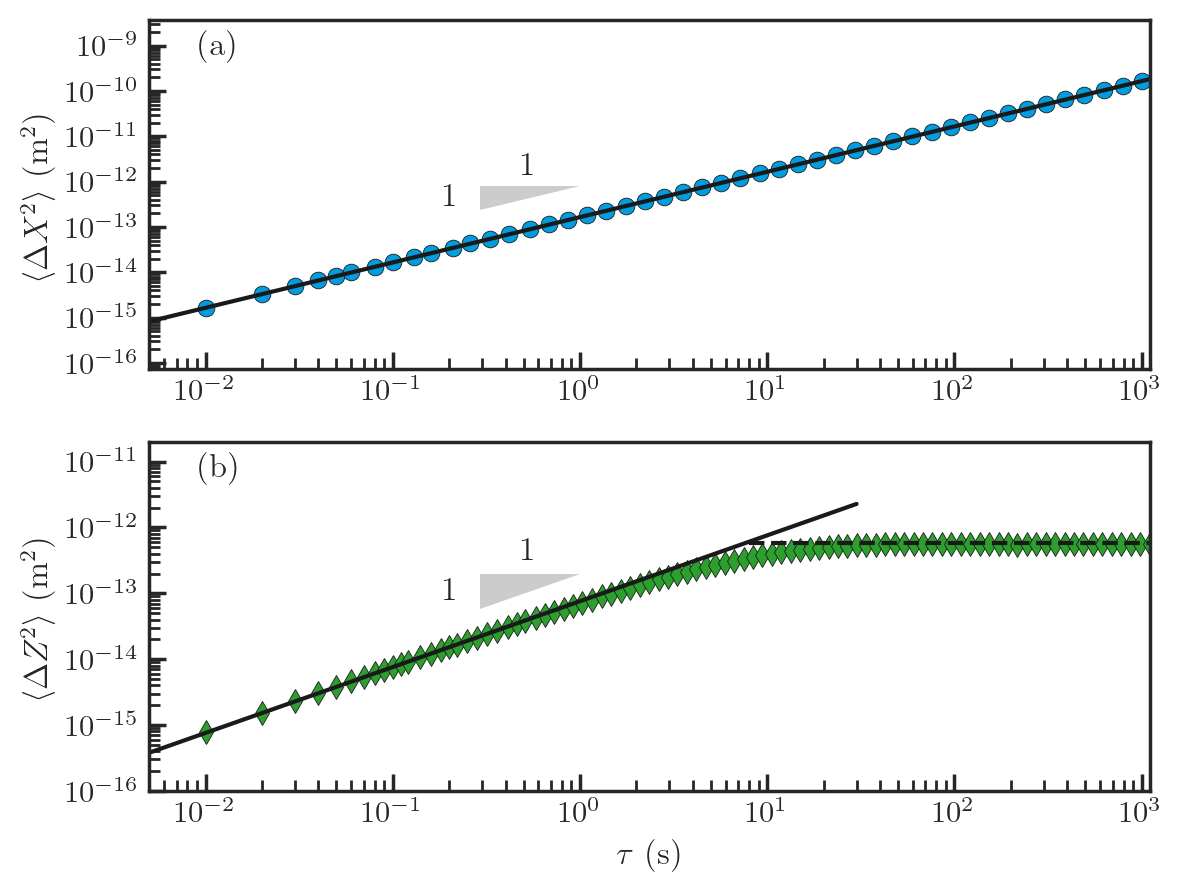

In [345]:
plt.figure(figsize=(1.8 * 3.375, 2.3 * 3.375 / 1.68), tight_layout=True)
taille_marque = 6

ax1 = plt.subplot(211)
ax1.loglog(Moments["tau_x"], Moments["<x2>"], "o", color=BlueUB, markersize=taille_marque)
ax1.plot(tau_theo, 2*mean_Dx*tau_theo, "-", color="k")#mediumblue
ax1.set(
    # xlabel = r"$\tau ~\mathrm{(s)}$",
    ylabel = r"$\langle \Delta X^2 \rangle~(\mathrm{m}^2)$",
    xlim=(dt/2, dt*Nt/9),
    # ylim=(1e-16*1e12, 2e-10*1e12),
)
annotation.slope_marker((1, 8e-13), (1, 1), ax=ax1, invert=True)
ax1.text(0.05, 0.9, r"(a)", transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_xticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%1==0:i.set_visible(True)
    

    
    
ax2 = plt.subplot(212)
ax2.loglog(Moments["tau_z"][:], Moments["<z2>"][:], "d", color="tab:green")
ax2.plot(tau_short, 2*mean_Dz*tau_short, "-", color="k") #darkgreen
ax2.plot(tau_z_long, plateauZ*np.ones(len(tau_z_long)), "--", color="k")
ax2.set(
    xlabel = r"$\tau ~\mathrm{(s)}$",
    ylabel = r"$\langle \Delta Z^2 \rangle~(\mathrm{m}^2)$",
    xlim=(dt/2, dt*Nt/9),
    ylim=(1e-16, 2e-11),
)
annotation.slope_marker((1, 2e-13), (1, 1), ax=ax2, invert=True)
ax2.text(0.05, 0.9, r"(b)", transform=ax2.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.xaxis.set_major_locator(locmaj)
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2_ticks = ax2.get_xticklabels()
for i in ax2_ticks:
    i.set_visible(False)
for n, i in enumerate(ax2_ticks):
    if n%1==0:i.set_visible(True)
    
plt.savefig("Figures/Moments2.pdf")

# Cumulants $4$

In [295]:
#Theoritical values
# D4_long_theo = 1.2691e-27 #1.5074e-27
# C4_long_theo = 1.0350e-26 #1.4039e-26
A4_theo_x, D4_long_theo, C4_long_theo = (2.335706168867776e-27, 1.2691e-27, 1.035e-26)
A4_theo_z = 4.063937162518948e-27
# A4_theo_x = C4_short(D=D_x, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta0, dx=1e-8)
# A4_theo_z = C4_short(D=D_z, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta0, dx=1e-8)

In [173]:
plateauC4z = np.trapz(dz_theo**4 * P_dZ_longTime , dz_theo) - 3 * np.trapz(dz_theo**2 * P_dZ_longTime , dz_theo) ** 2 

In [178]:
tau_x_long = np.linspace(20, 1e4,1000)

In [176]:
#Theory all time
analytic = np.loadtxt('Large_Gap/THEORY_EIGENVALUES_FOR_C4.txt',dtype="float" )

analytic_time = analytic[:,0]
analytic_C4 = analytic[:,1]
analytic_kurtosis = ((analytic_C4 + 3*(2*mean_Dx*analytic_time)**2) / (2*mean_Dx*analytic_time)**2) - 3

In [15]:
## EXPERIENCE from FARÉS
experience = loadmat("Large_Gap/C4_kurtosis_semi_experimental_exp_20211019_from_20221003.mat")
experience_C4 = experience["C4"][0]
experience_errC4 = experience["err_C4"][0]
experience_Kurtosis = experience["kurtosis"][0]
experience_errKurtosis = experience["err_kurtosis"][0]
experience_time = experience["time"][0]

experience_dX_0p01 = experience["pdf_0"]["bins_center"][0][0][0]
experience_PDF_0p01 = experience["pdf_0"]["pdf"][0][0][0]
experience_PDFstd_0p01 = experience["pdf_0"]["pdf_err"][0][0][0]

experience_dX_1 = experience["pdf_2"]["bins_center"][0][0][0]
experience_PDF_1 = experience["pdf_2"]["pdf"][0][0][0]
experience_PDFstd_1 = experience["pdf_2"]["pdf_err"][0][0][0]
# experience

In [167]:
Cumulants =  loadmat("Large_Gap/SIMU_Cumulants_Nt_1e6_dt_1e-2.mat", squeeze_me=True)

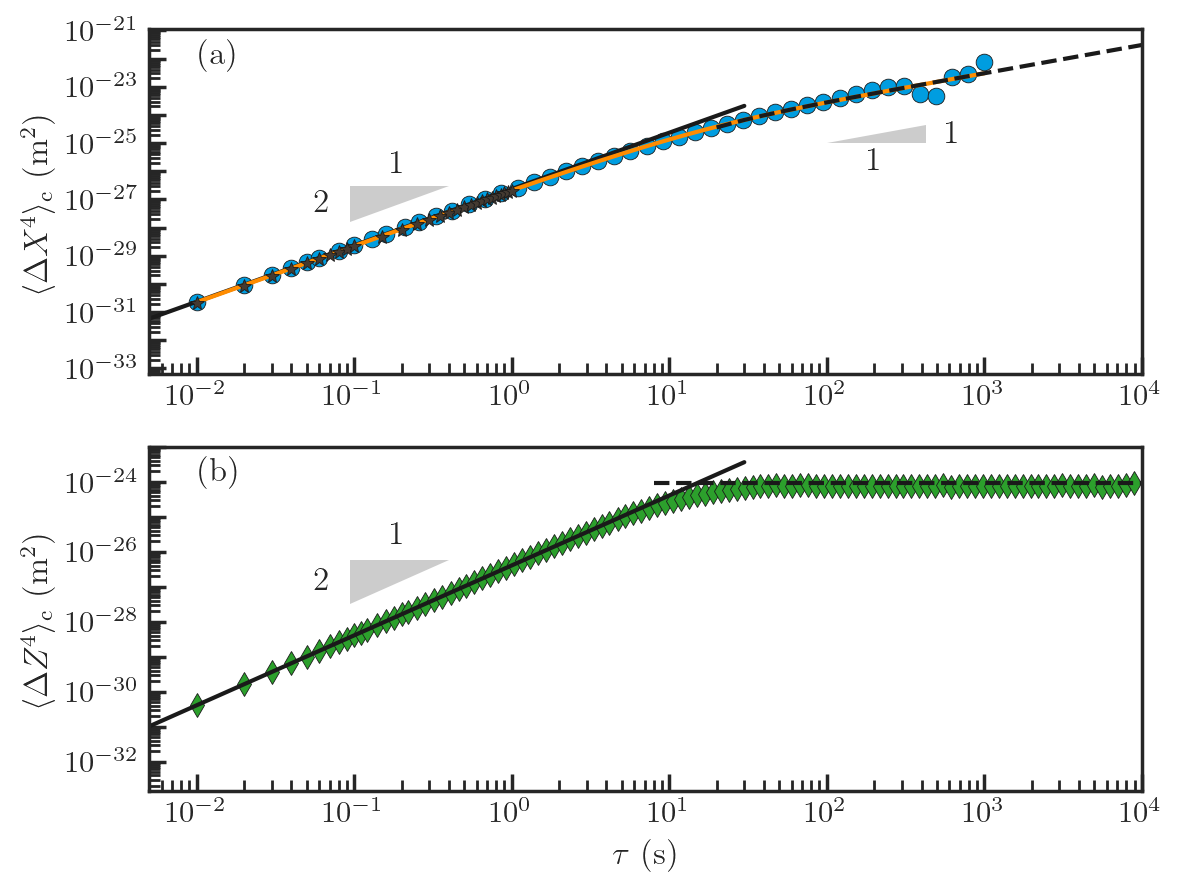

In [296]:
plt.figure(figsize=(1.8 * 3.375, 2.3 * 3.375 / 1.68), tight_layout=True)
taille_marque = 6

ax1 = plt.subplot(211)
ax1.loglog(Cumulants["tau_x"], Cumulants["<x4>"], "o", color=BlueUB)
ax1.plot(tau_short, A4_theo_x*tau_short**2, "-", color="k")
ax1.plot(analytic_time, analytic_C4, "-", color="darkorange", label="Theory")
ax1.plot(tau_x_long, 24*(D4_long_theo*tau_x_long - C4_long_theo), "--", color="k")
ax1.errorbar(experience_time[:-3], experience_C4[:-3], yerr=experience_errC4[:-3], fmt='*', linestyle="",color=BrownUB, markersize=taille_marque-1)

ax1.set(
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{m}^2)$",
    xlim=(dt/2, dt*Nt),
)
annotation.slope_marker((4e-1, 3e-27), (2, 1), ax=ax1, invert=True)
annotation.slope_marker((1e2,1e-25), (1, 1), ax=ax1, invert=False)
ax1.text(0.05, 0.9, r"(a)", transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)
    

    
    
ax2 = plt.subplot(212)
ax2.loglog(Cumulants["tau_z"], Cumulants["<z4>"], "d", color="tab:green", markersize=taille_marque)
ax2.plot(tau_short, A4_theo_z*tau_short**2, "-", color="k")
ax2.plot(tau_z_long, plateauC4z*np.ones(len(tau_z_long)), "--", color="k")
ax2.set(
    xlabel = r"$\tau ~\mathrm{(s)}$",
    ylabel = r"$\langle \Delta Z^4 \rangle_\mathrm{c}~(\mathrm{m}^2)$",
    xlim=(dt/2, dt*Nt),
)
annotation.slope_marker((4e-1, 6e-27), (2, 1), ax=ax2, invert=True)
ax2.text(0.05, 0.9, r"(b)", transform=ax2.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.xaxis.set_major_locator(locmaj)
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2_ticks = ax2.get_yticklabels()
for i in ax2_ticks:
    i.set_visible(False)
for n, i in enumerate(ax2_ticks):
    if n%2==0:i.set_visible(True)
    
plt.savefig("Figures/Cumulants4.pdf")

# Kurtosis

In [280]:
Kurtosis = loadmat("Large_Gap/SIMU_Kurtosis_Nt_1e6_dt_1e-2.mat", squeeze_me=True)

In [34]:
mean_Dx2 = np.trapz(Peq_normalised*D_x(z_theo, a, eta0, H)**2, z_theo)

In [42]:
Kurto_plateau = 3*(mean_Dx2/mean_Dx**2 - 1 )
Kurto_plateau

0.08429727108168072

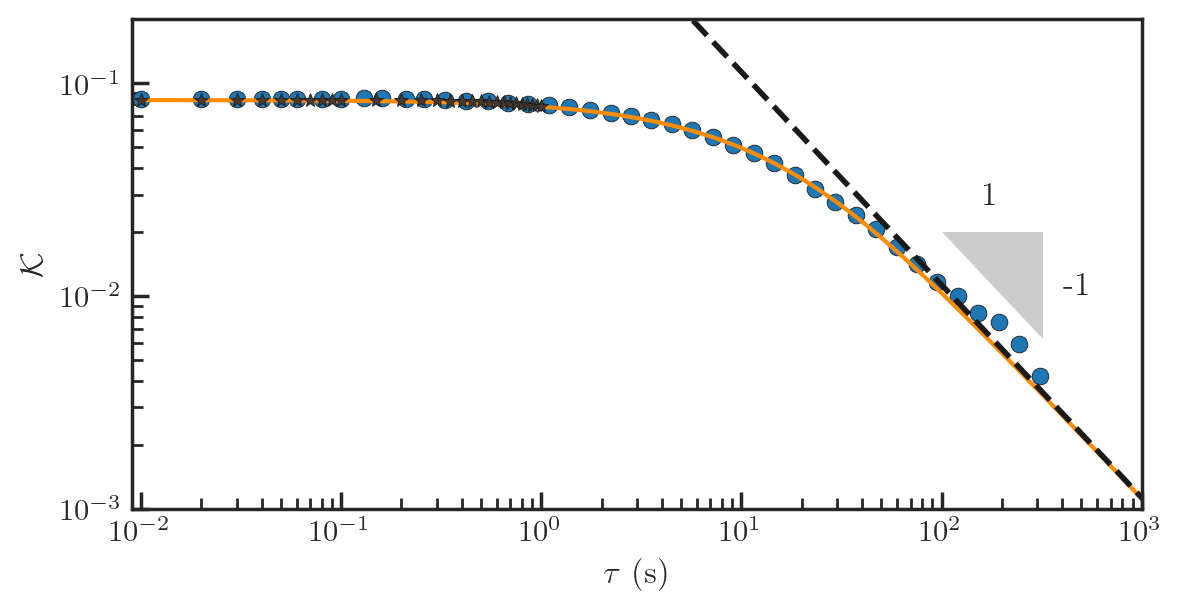

In [386]:
plt.figure(figsize=(1.8 * 3.375, 1.6* 3.375 / 1.68), tight_layout=True)
taille_marque = 6
t_infinity = np.linspace(1, 1e4, 10000)

####C4
ax1 = plt.subplot(111)
ax1.loglog(Kurtosis["tau_x"][:-5], np.array(Kurtosis["x"][:-5]), "o", color="tab:blue", markersize=taille_marque, label="$X_t$")
ax1.errorbar(experience_time[:-3], experience_Kurtosis [:-3], yerr=experience_errKurtosis[:-3], fmt='*', linestyle="",color=BrownUB, markersize=taille_marque-1)
# ax1.plot(t_short, Kurto_plateau*np.ones(len(t_short)), "-", color="black", linewidth=2.)
ax1.plot(analytic_time, analytic_kurtosis, "-", color="darkorange", label="Theory", markersize=taille_marque)
ax1.plot(t_infinity, (6*D4_long_theo/(mean_Dx**2*t_infinity)), "--", color="k", linewidth=2. )

ax1.set_ylim(1e-3, 2e-1)
ax1.set_xlim(9e-3, 1e3)
ax1.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\mathcal{K}$",
)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

annotation.slope_marker((100, 2e-2), (-1, 1), ax=ax1, invert=False)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# ax1_ticks = ax1.get_yticklabels()
# for i in ax1_ticks:
#     i.set_visible(False)
# for n, i in enumerate(ax1_ticks):
#     if n%2==0:i.set_visible(True)

plt.savefig("Figures/Kurtosis.pdf")

# Numerical convergence of $\langle \Delta X^4 \rangle_\mathrm{c}$

In [367]:
# dX theory
dxCOURT = np.linspace(-0.4e-6, 0.4e-6, 1000)
dxMID = np.linspace(-15e-6,15e-6, 1000)
dxLONG = np.linspace(-60e-6, 60e-6, 1000)

# Gaussian theories
Gauss_x0 = gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*List_tau[0]))
Gauss_x1 = gauss(dxMID, 0, np.sqrt(2*mean_Dx*List_tau[1]))
Gauss_x2 = gauss(dxLONG, 0, np.sqrt(2*mean_Dx*List_tau[2]))
Gauss_x3 = gauss(dxLONG, 0, np.sqrt(2*mean_Dx*List_tau[3]))

# Theorie
PDF_theory_x_short = P_Di_short_time(dxCOURT, List_tau[0], D_x, a, eta0, B, lD, lB, H)
PDF_theory_x_mid =  P_Di_short_time(dxMID, List_tau[1], D_x, a, eta0, B, lD, lB, H)
PDF_theory_x_long = P_Di_short_time(dxLONG, List_tau[2], D_x, a, eta0, B, lD, lB, H)
PDF_theory_x_long3 = P_Di_short_time(dxLONG, List_tau[3], D_x, a, eta0, B, lD, lB, H)

In [480]:
Sum_hist = loadmat("Large_Gap/SIMU_PFDs_for4tau_Ns-Min-Max.mat", squeeze_me=True)

P_tau0_Ns1 = Sum_hist["Ns=1, P(dX,tau1)"] 
P_tau0_Ns2e6 = Sum_hist["Ns=2097378, P(dX,tau1)"]

P_tau1_Ns1 = Sum_hist["Ns=1, P(dX,tau2)"] 
P_tau1_Ns2e6 = Sum_hist["Ns=2097378, P(dX,tau2)"] 

P_tau2_Ns1 = Sum_hist["Ns=1, P(dX,tau3)"] 
P_tau2_Ns2e6 = Sum_hist["Ns=2097378, P(dX,tau3)"] 

P_tau3_Ns1 = Sum_hist["Ns=1, P(dX,tau4)"] 
P_tau3_Ns2e6 = Sum_hist["Ns=2097378, P(dX,tau4)"]

dx_0, dx_1, dx_2, dx_3 = Sum_hist["dx_1,dx_2,dx_3, dx_4"]
List_tau = Sum_hist["tau"]

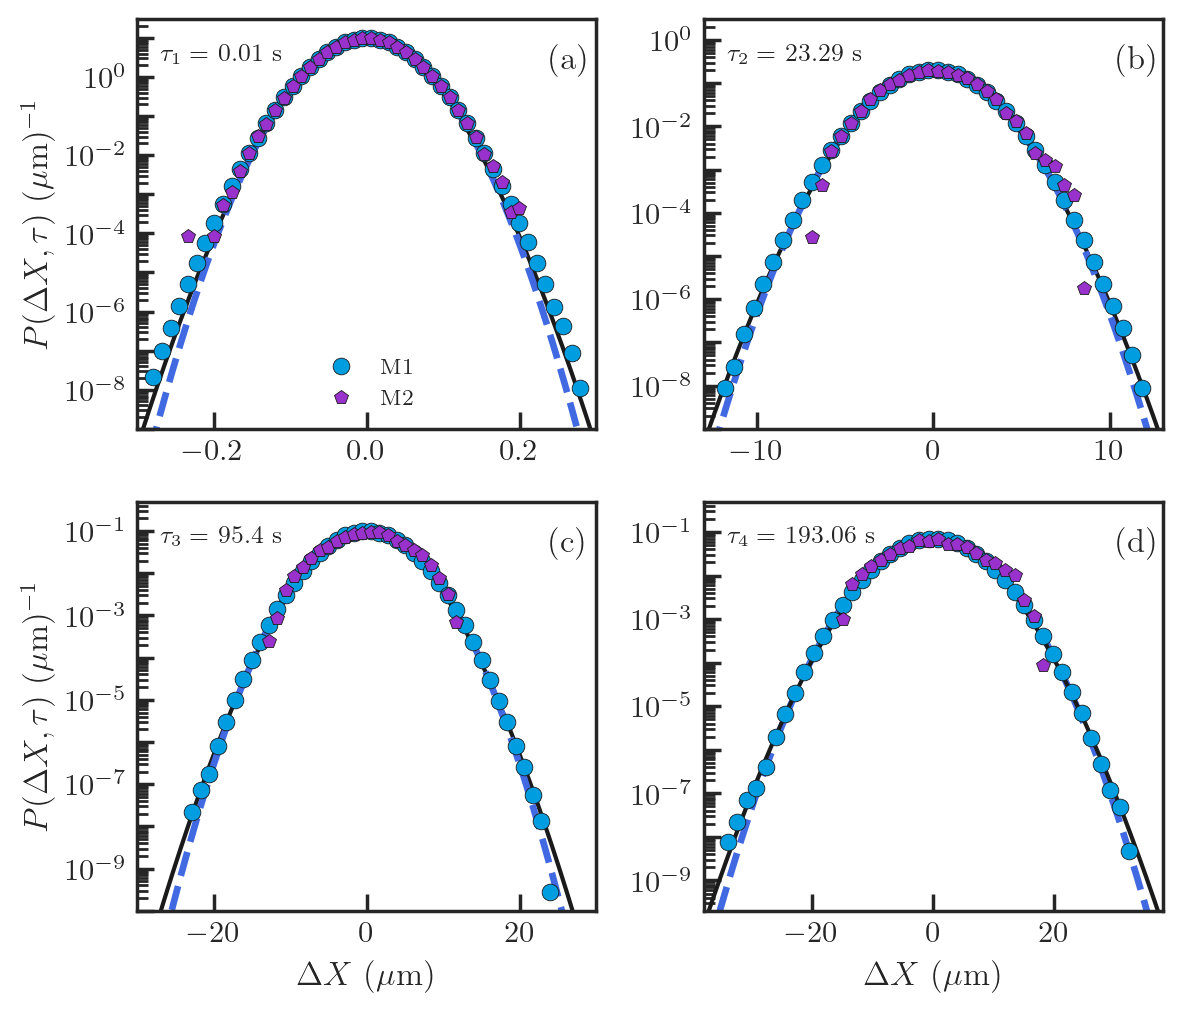

In [719]:
plt.figure(figsize=(1.8 * 3.375, 1.3 *2.0* 3.375 / 1.68), tight_layout=True)
taille_marque = 6

ax0 = plt.subplot(221)
ax0.semilogy(dxCOURT*1e6, PDF_theory_x_short/np.trapz(PDF_theory_x_short, dxCOURT*1e6), "-", color="k", linewidth=taille_ligne)
ax0.plot(dxCOURT*1e6, Gauss_x0/np.trapz(Gauss_x0,dxCOURT*1e6), "--", color="royalblue", linewidth=2.4)
ax0.semilogy(dx_0*1e6, P_tau0_Ns2e6/np.trapz(P_tau0_Ns2e6, dx_0*1e6), "o", color=BlueUB, markersize=taille_marque, label=r"M$1$")
ax0.semilogy(dx_0*1e6, P_tau0_Ns1/np.trapz(P_tau0_Ns1, dx_0*1e6), "p", color="darkorchid", markersize=taille_marque-1, label=r"M$2$")
ax0.set(
    ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
    xlim = (-0.3, 0.3),
    ylim = (1e-9, 3e1),
)
ax0.legend(loc='lower center', frameon=False, fontsize=8)
ax0.text(0.9, 0.88, r"(a)", transform=ax0.transAxes)
ax0.text(0.05, 0.9, r"$\tau_1 = $ "+ str(List_tau[0]) + " s", fontsize=9, transform=ax0.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.yaxis.set_major_locator(locmaj)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax0_ticks = ax0.get_yticklabels()
for i in ax0_ticks:
    i.set_visible(False)
for n, i in enumerate(ax0_ticks):
    if n%2==0:i.set_visible(True)
    
ax1 = plt.subplot(222)
ax1.semilogy(dxMID*1e6, PDF_theory_x_mid/np.trapz(PDF_theory_x_mid, dxMID*1e6), "-", color="k", linewidth=taille_ligne)##
ax1.plot(dxMID*1e6, Gauss_x1/np.trapz(Gauss_x1,dxMID*1e6), "--", color="royalblue", linewidth=2.4)
ax1.semilogy(dx_1*1e6, P_tau1_Ns2e6/np.trapz(P_tau1_Ns2e6, dx_1*1e6), "o", color=BlueUB, markersize=taille_marque)
ax1.semilogy(dx_1*1e6, P_tau1_Ns1/np.trapz(P_tau1_Ns1, dx_1*1e6), "p" , color="darkorchid", markersize=taille_marque-1)
    
ax1.set(
    xlim = (-13, 13),
    ylim = (1e-9, 3e0),
)
ax1.text(0.9, 0.88, r"(b)", transform=ax1.transAxes)
ax1.text(0.05, 0.9, r"$\tau_2 = $ "+ str(List_tau[1]) + " s", fontsize=9, transform=ax1.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax1.yaxis.set_major_locator(locmaj)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1_ticks = ax1.get_yticklabels()
for i in ax1_ticks:
    i.set_visible(False)
for n, i in enumerate(ax1_ticks):
    if n%2==0:i.set_visible(True)

    
    
#####################
ax2 = plt.subplot(223)#Short X
ax2.semilogy(dxLONG*1e6, PDF_theory_x_long/np.trapz(PDF_theory_x_long, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
ax2.plot(dxLONG*1e6, Gauss_x2/np.trapz(Gauss_x2,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
ax2.semilogy(dx_2*1e6, P_tau2_Ns2e6/np.trapz(P_tau2_Ns2e6, dx_2*1e6), "o" , color=BlueUB, markersize=taille_marque)
ax2.semilogy(dx_2*1e6, P_tau2_Ns1/np.trapz(P_tau2_Ns1, dx_2*1e6), "p", color="darkorchid", markersize=taille_marque-1)
ax2.set(
    xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
    ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
    xlim = (-30, 30),
    ylim = (1e-10, 5e-1),
)
ax2.text(0.9, 0.88, r"(c)", transform=ax2.transAxes)
ax2.text(0.05, 0.9, r"$\tau_3 = $ "+ str(List_tau[2]) + " s", fontsize=9, transform=ax2.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax2.yaxis.set_major_locator(locmaj)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2_ticks = ax2.get_yticklabels()
for i in ax2_ticks:
    i.set_visible(False)
for n, i in enumerate(ax2_ticks):
    if n%2==0:i.set_visible(True)

    
    
#####################
ax3 = plt.subplot(224)#Long X
ax3.plot(dxLONG*1e6, Gauss_x3/np.trapz(Gauss_x3,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
ax3.semilogy(dxLONG*1e6, PDF_theory_x_long3/np.trapz(PDF_theory_x_long3, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
ax3.semilogy(dx_3*1e6, P_tau3_Ns2e6/np.trapz(P_tau3_Ns2e6, dx_3*1e6), "o", color=BlueUB, markersize=taille_marque)
ax3.semilogy(dx_3*1e6, P_tau3_Ns1/np.trapz(P_tau3_Ns1, dx_3*1e6), "p" , color="darkorchid", markersize=taille_marque-1)
ax3.set(
    xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
    xlim = (-38, 38),
    ylim = (2e-10, 5e-1),
)
ax3.text(0.9, 0.88, r"(d)", transform=ax3.transAxes)
ax3.text(0.05, 0.9, r"$\tau_4 = $ "+ str(List_tau[3]) + " s", fontsize=9, transform=ax3.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax3.yaxis.set_major_locator(locmaj)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax3_ticks = ax3.get_yticklabels()
for i in ax3_ticks:
    i.set_visible(False)
for n, i in enumerate(ax3_ticks):
    if n%2==0:i.set_visible(True)

plt.savefig("Figures/ConvergencePDFsX.pdf")

## Methodes M1 and M2

In [375]:
# Index of times \tau studies
n_mid = -17
n_long = -11
n_inf = -8

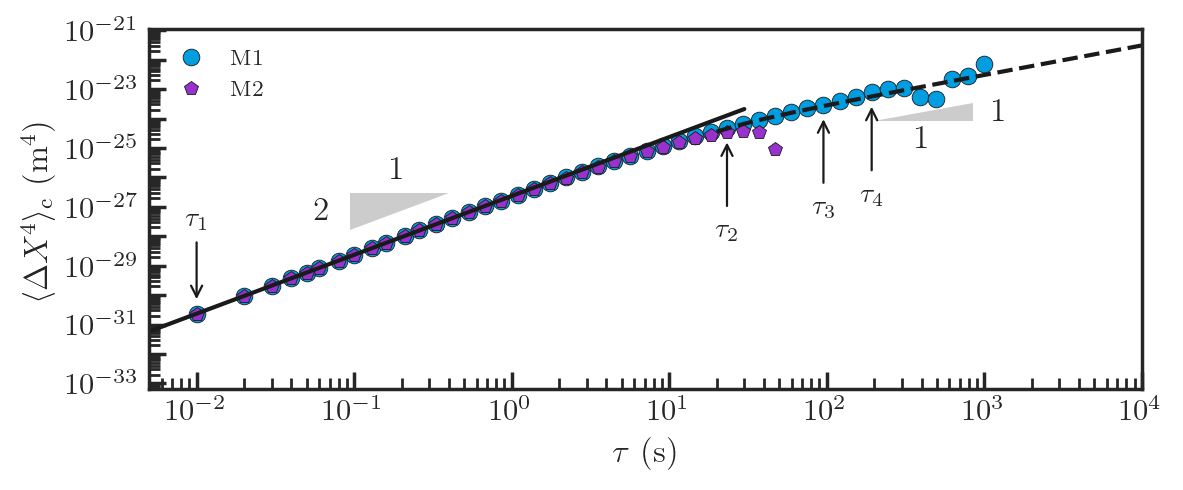

In [484]:
plt.figure(figsize=(1.8 * 3.375, 1.3 * 3.375 / 1.68), tight_layout=True)
taille_marque = 6
ColorM2 = "darkorchid"

ax0 = plt.subplot(111)
ax0.loglog(Cumulants["tau_x"], Cumulants["<x4>"], "o", color=BlueUB, markersize=taille_marque, label=r"M$1$")
ax0.loglog(Cumulants["tau_x"], Cumulants['<x4> by avering over Ns <x4>'], "p", color=ColorM2, markersize=taille_marque-1, label=r"M$2$")
ax0.plot(tau_short, A4_theo_x*tau_short**2, "-", color="k")
ax0.plot(tau_x_long, 24*(D4_long_theo*tau_x_long - C4_long_theo), "--", color="k")
ax0.annotate(r"$\tau _1$", (dts[0], Cumulants["<x4>"][0]*2), 
             xytext=(dts[0], Cumulants["<x4>"][0]*1000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
ax0.annotate(r"$\tau _2$", (dts[1], Cumulants["<x4>"][n_mid]/2), 
             xytext=(dts[1], Cumulants["<x4>"][n_mid]/5000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
ax0.annotate(r"$\tau _3$", (dts[2], Cumulants["<x4>"][n_long]/2),
             xytext=(dts[2], Cumulants["<x4>"][n_long]/5000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
ax0.annotate(r"$\tau _4$", (dts[3], Cumulants["<x4>"][n_inf]/2),
             xytext=(dts[3], Cumulants["<x4>"][n_inf]/5000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
# ax0.plot(analytic_time, analytic_C4, "-", color="darkorange", label="Theory")
ax0.legend(loc='upper left', frameon=False, fontsize=8)
ax0.set(
    xlabel = r"$\tau ~\mathrm{(s)}$",
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{m}^4)$",
    xlim=(dt/2, dt*Nt),
)
annotation.slope_marker((4e-1, 3e-27), (2, 1), ax=ax0, invert=True)
annotation.slope_marker((2e2,8e-25), (1, 1), ax=ax0, invert=False)
# ax0.text(0.05, 0.9, r"(a)", transform=ax0.transAxes)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.yaxis.set_major_locator(locmaj)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
ax0.xaxis.set_major_locator(locmaj)
ax0.xaxis.set_minor_locator(locmin)
ax0.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax0_ticks = ax0.get_yticklabels()
for i in ax0_ticks:
    i.set_visible(False)
for n, i in enumerate(ax0_ticks):
    if n%2==0:i.set_visible(True)
    
plt.savefig("Figures/C4_methodes1&2.pdf")

# Plot convergence $\langle \Delta X^4 \rangle_\mathrm{c}$ for $\tau_1, \tau_2, \tau_3$

In [346]:
Convergences =  loadmat("Large_Gap/SIMU_ConvergencesC4_Nt_1e6_dt_1e-2.mat", squeeze_me=True)

In [347]:
C4x_Ns_0 = Convergences["M1_tau1"]
C4x_Ns_1 = Convergences["M1_tau2"]
C4x_Ns_2 = Convergences["M1_tau3"]
C4x_Ns_3 = Convergences["M1_tau4"]

C4x_Ns_0_M2 = Convergences["M2_tau1"]
C4x_Ns_1_M2 = Convergences["M2_tau2"]
C4x_Ns_2_M2 = Convergences["M2_tau3"]
C4x_Ns_3_M2 = Convergences["M2_tau4"] 

List_Ns = Convergences["Liste_Ns"]
List_tau = Convergences["tau_i"]

In [348]:
#Theoritical values
Convergence_tau1 = A4_theo_x*List_tau[0]**2
Convergence_tau2 = (24*D4_long_theo*List_tau[1] - 24*C4_long_theo)
Convergence_tau3 = (24*D4_long_theo*List_tau[2] - 24*C4_long_theo)
Convergence_tau4 = (24*D4_long_theo*List_tau[3] - 24*C4_long_theo)
Convergence_tau1, Convergence_tau2, Convergence_tau3, Convergence_tau4
Ns_theo = np.linspace(1e2, 1e7, 1000)

(2.335706168867776e-31, 4.609761359999998e-25, 2.65733136e-24, 5.631898704e-24)

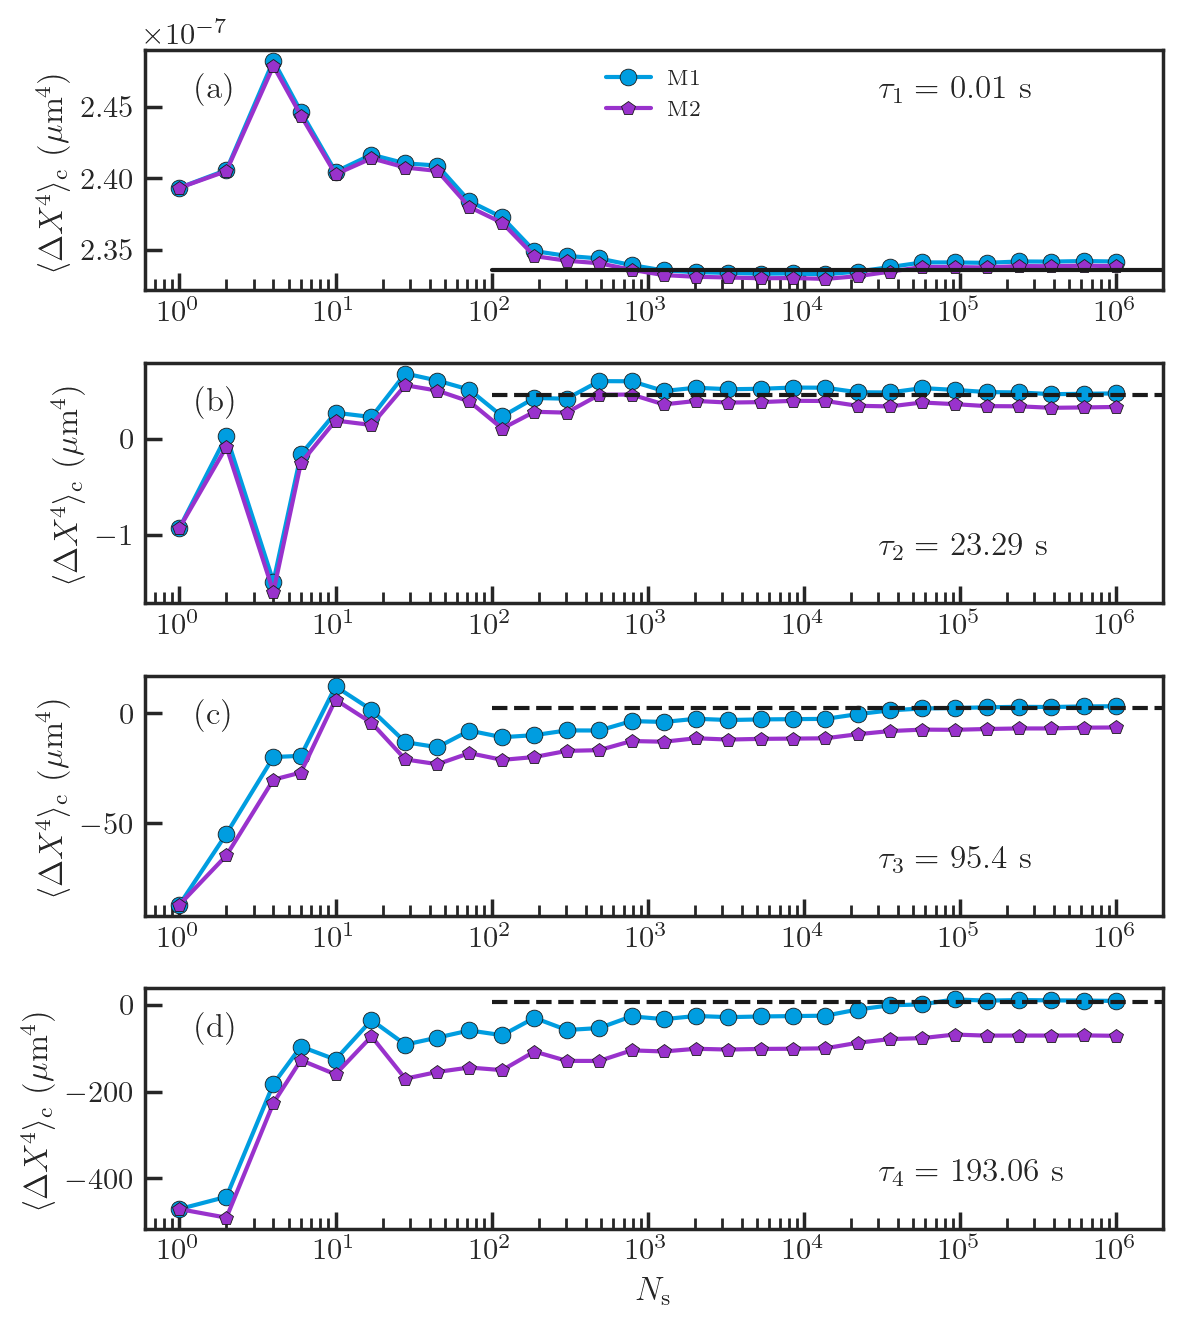

In [487]:
plt.figure(figsize=(1.8 * 3.375, 1.3 *2.6* 3.375 / 1.68), tight_layout=True)
taille_marque = 6
 
    
ax1 = plt.subplot(411)
ax1.semilogx(List_Ns, C4x_Ns_0*1e24, "-o", color=BlueUB, markersize=taille_marque, label=r"M$1$")
ax1.semilogx(List_Ns, C4x_Ns_0_M2*1e24, "-p", color=ColorM2, markersize=taille_marque-1, label=r"M$2$")
ax1.plot(Ns_theo, Convergence_tau1*1e24*np.ones(len(Ns_theo)), "-", color="k")
ax1.text(0.05, 0.8, r"(a)", transform=ax1.transAxes)
ax1.text(0.72, 0.8, r"$\tau_1 = $ "+ str(List_tau[0]) + " s", transform=ax1.transAxes)
ax1.legend(loc='upper center', frameon=False, fontsize=8)
ax1.set(
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{\mu m}^4)$",
    xlim=(6e-1, 2e6),
)


########################
ax2 = plt.subplot(412)
ax2.semilogx(List_Ns, C4x_Ns_1*1e24, "-o", color=BlueUB, markersize=taille_marque)
ax2.semilogx(List_Ns, C4x_Ns_1_M2*1e24, "-p", color=ColorM2, markersize=taille_marque-1)
ax2.plot(Ns_theo, Convergence_tau2*1e24*np.ones(len(Ns_theo)), "--", color="k")
ax2.text(0.05, 0.8, r"(b)", transform=ax2.transAxes)
ax2.text(0.72, 0.2, r"$\tau_2 = $ "+ str(List_tau[1]) + " s", transform=ax2.transAxes)
ax2.set(
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{\mu m}^4)$",
    xlim=(6e-1, 2e6),
)


#########################
ax3 = plt.subplot(413)
ax3.semilogx(List_Ns, C4x_Ns_2*1e24, "-o", color=BlueUB, markersize=taille_marque)
ax3.semilogx(List_Ns, C4x_Ns_2_M2*1e24, "-p", color=ColorM2, markersize=taille_marque-1)
ax3.plot(Ns_theo, Convergence_tau3*1e24*np.ones(len(Ns_theo)), "--", color="k")
ax3.text(0.05, 0.8, r"(c)", transform=ax3.transAxes)
ax3.text(0.72, 0.2, r"$\tau_3 = $ "+ str(List_tau[2]) + " s", transform=ax3.transAxes)
ax3.set(
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{\mu m}^4)$",
    xlim=(6e-1, 2e6),
)

#########################
ax4 = plt.subplot(414)
ax4.semilogx(List_Ns, C4x_Ns_3*1e24, "-o", color=BlueUB, markersize=taille_marque)
ax4.semilogx(List_Ns, C4x_Ns_3_M2*1e24, "-p", color=ColorM2, markersize=taille_marque-1)
ax4.plot(Ns_theo, Convergence_tau4*1e24*np.ones(len(Ns_theo)), "--", color="k")
ax4.text(0.05, 0.8, r"(d)", transform=ax4.transAxes)
ax4.text(0.72, 0.2, r"$\tau_4 = $ "+ str(List_tau[3]) + " s", transform=ax4.transAxes)
ax4.set(
    xlabel = r"$N_\mathrm{s}$",
    ylabel = r"$\langle \Delta X^4 \rangle_\mathrm{c}~(\mathrm{\mu m}^4)$",
    xlim=(6e-1, 2e6),
)

plt.tight_layout()

plt.savefig("Figures/ConvergencesC4.pdf")

## PDF and quantile

- PDF_tot are made with np.sum(data, axis=0) of PDF over Ns trajectories
- Quantil order q are made with np.quantil(data, q= ,axis=0 ).

In [475]:
# ConvergencesPDFs = loadmat("Large_Gap/SIMU_ConvergencesPFDs_quantiles_Nt_1e6_dt_1e-2.mat", squeeze_me=True)

# dx_0 , pdf0_tot, pdf0_99th, pdf0_90th = ConvergencesPDFs["dx_0, sum_PDF0, quantil99_PDF0, quantil90_PDF0"] 
# dx_1 , pdf1_tot, pdf1_99th, pdf1_90th = ConvergencesPDFs["dx_1, sum_PDF1, quantil99_PDF1, quantil90_PDF1"]
# dx_2 , pdf2_tot, pdf2_99th, pdf2_90th = ConvergencesPDFs["dx_2, sum_PDF2, quantil99_PDF2, quantil90_PDF2"] 
# dx_3 , pdf3_tot, pdf3_99th, pdf3_90th = ConvergencesPDFs["dx_3, sum_PDF3, quantil99_PDF3, quantil90_PDF3"] 
# List_tau = ConvergencesPDFs["tau_i"]
# List_tau

In [460]:
# plt.figure(figsize=(1.8 * 3.375, 2* 1.3 * 3.375 / 1.68), tight_layout=True)
# taille_marque = 6
# taille_ligne = 1.2
# color90 = "lavender"
# color99 = "darkslateblue"

# ####################
# #####################
# ax0 = plt.subplot(221)#Short X
# # ax0.semilogy(theo_dx_0, theo_PDF_x0, "-", color="darkorange", linewidth=taille_ligne)
# # ax0.semilogy(-theo_dx_0, theo_PDF_x0, "-", color="darkorange", linewidth=taille_ligne)
# ax0.semilogy(dxCOURT*1e6, PDF_theory_x_short/np.trapz(PDF_theory_x_short, dxCOURT*1e6), "-", color="k", linewidth=taille_ligne)
# ax0.plot(dxCOURT*1e6, Gauss_x0/np.trapz(Gauss_x0,dxCOURT*1e6), "--", color="royalblue", linewidth=2.4)
# ax0.semilogy(dx_0*1e6, pdf0_tot/np.trapz(pdf0_tot,dx_0*1e6), "o", color=BlueUB, markersize=taille_marque)
# ax0.semilogy(dx_0*1e6, pdf0_99th/np.trapz(pdf0_99th,dx_0*1e6), "^", color=color99, markersize=taille_marque-1)
# ax0.semilogy(dx_0*1e6, pdf0_90th/np.trapz(pdf0_90th,dx_0*1e6), "s", color=color90, markersize=taille_marque-2)
# ax0.set(
#     # xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
#     ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
#     xlim = (-0.3, 0.3),
#     ylim = (1e-9, 3e1),
# )
# ax0.text(0.9, 0.88, r"(a)", transform=ax0.transAxes)
# ax0.text(0.05, 0.9, r"$\tau_1 = $ "+ str(List_tau[0]) + " s", fontsize=9, transform=ax0.transAxes)
# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
# ax0.yaxis.set_major_locator(locmaj)
# ax0.yaxis.set_minor_locator(locmin)
# ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# ax0_ticks = ax0.get_yticklabels()
# for i in ax0_ticks:
#     i.set_visible(False)
# for n, i in enumerate(ax0_ticks):
#     if n%2==0:i.set_visible(True)
    
    
  
# ax1 = plt.subplot(222)
# ax1.semilogy(dxMID*1e6, PDF_theory_x_mid/np.trapz(PDF_theory_x_mid, dxMID*1e6), "-", color="k", linewidth=taille_ligne)##
# ax1.plot(dxMID*1e6, Gauss_x1/np.trapz(Gauss_x1,dxMID*1e6), "--", color="royalblue", linewidth=2.4)
# ax1.semilogy(dx_1*1e6, pdf1_tot/np.trapz(pdf1_tot,dx_1*1e6), "o", color=BlueUB, markersize=taille_marque)
# ax1.semilogy(dx_1*1e6, pdf1_99th/np.trapz(pdf1_99th,dx_1*1e6), "^", color=color99, markersize=taille_marque-1)
# ax1.semilogy(dx_1*1e6, pdf1_90th/np.trapz(pdf1_90th,dx_1*1e6), "s", color=color90, markersize=taille_marque-2)

# ax1.set(
#     # xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
#     # ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
#     xlim = (-13, 13),
#     ylim = (1e-9, 3e0),
# )
# ax1.text(0.9, 0.88, r"(b)", transform=ax1.transAxes)
# ax1.text(0.05, 0.9, r"$\tau_2 = $ "+ str(List_tau[1]) + " s", fontsize=9, transform=ax1.transAxes)
# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
# ax1.yaxis.set_major_locator(locmaj)
# ax1.yaxis.set_minor_locator(locmin)
# ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# ax1_ticks = ax1.get_yticklabels()
# for i in ax1_ticks:
#     i.set_visible(False)
# for n, i in enumerate(ax1_ticks):
#     if n%2==0:i.set_visible(True)

    
    
# #####################
# ax2 = plt.subplot(223)#Short X
# ax2.semilogy(dxLONG*1e6, PDF_theory_x_long/np.trapz(PDF_theory_x_long, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
# ax2.plot(dxLONG*1e6, Gauss_x2/np.trapz(Gauss_x2,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
# ax2.semilogy(dx_2*1e6, pdf2_tot/np.trapz(pdf2_tot,dx_2*1e6), "o", color=BlueUB, markersize=taille_marque)
# ax2.semilogy(dx_2*1e6, pdf2_99th/np.trapz(pdf2_99th,dx_2*1e6), "^", color=color99, markersize=taille_marque-1)
# ax2.semilogy(dx_2*1e6, pdf2_90th/np.trapz(pdf2_90th,dx_2*1e6), "s", color=color90, markersize=taille_marque-2)

# ax2.set(
#     xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
#     ylabel = r"$P(\Delta X, \tau)~(\mathrm{\mu m})^{-1}$",
#     xlim = (-30, 30),
#     ylim = (1e-11, 5e-1),
# )
# ax2.text(0.9, 0.88, r"(c)", transform=ax2.transAxes)
# ax2.text(0.05, 0.9, r"$\tau_3 = $ "+ str(List_tau[2]) + " s", fontsize=9, transform=ax2.transAxes)
# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
# ax2.yaxis.set_major_locator(locmaj)
# ax2.yaxis.set_minor_locator(locmin)
# ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# ax2_ticks = ax2.get_yticklabels()
# for i in ax2_ticks:
#     i.set_visible(False)
# for n, i in enumerate(ax2_ticks):
#     if n%2==0:i.set_visible(True)

    
    
# #####################
# ax3 = plt.subplot(224)#Long X
# ax3.plot(dxLONG*1e6, Gauss_x3/np.trapz(Gauss_x3,dxLONG*1e6), "--", color="royalblue", linewidth=2.4)
# ax3.semilogy(dxLONG*1e6, PDF_theory_x_long3/np.trapz(PDF_theory_x_long3, dxLONG*1e6), "-", color="k", linewidth=taille_ligne)
# ax3.semilogy(dx_3*1e6, pdf3_tot/np.trapz(pdf3_tot,dx_3*1e6), "o", color=BlueUB, markersize=taille_marque)
# ax3.semilogy(dx_3*1e6, pdf3_99th/np.trapz(pdf3_99th,dx_3*1e6), "^", color=color99, markersize=taille_marque-1)
# ax3.semilogy(dx_3*1e6, pdf3_90th/np.trapz(pdf3_90th,dx_3*1e6), "s", color=color90, markersize=taille_marque-2)

# ax3.set(
#     xlabel = r"$\Delta X~\mathrm{(\mu m)}$", 
#     xlim = (-38, 38),
#     ylim = (2e-10, 5e-1),
# )
# ax3.text(0.9, 0.88, r"(d)", transform=ax3.transAxes)
# ax3.text(0.05, 0.9, r"$\tau_4 = $ "+ str(List_tau[3]) + " s", fontsize=9, transform=ax3.transAxes)
# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
# ax3.yaxis.set_major_locator(locmaj)
# ax3.yaxis.set_minor_locator(locmin)
# ax3.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# ax3_ticks = ax3.get_yticklabels()
# for i in ax3_ticks:
#     i.set_visible(False)
# for n, i in enumerate(ax3_ticks):
#     if n%2==0:i.set_visible(True)
    
# plt.savefig("Figures/ConvergencePDFsX.pdf")